In [1]:
# --- Standard Library ---
import os
from pathlib import Path

# --- Third-Party Libraries ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [2]:
# Set the maximum number of columns to display 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
BASE_DIR = Path("../data/processed")  

df_srag = pd.read_parquet(f"{BASE_DIR}/df_srag.parquet")

## Ajuste final nos dados

In [5]:
df_srag.dtypes

source         object
NU_NOTIFIC      int64
DT_NOTIFIC     object
CLASSI_FIN    float64
EVOLUCAO      float64
DT_ENCERRA     object
UTI           float64
VACINA        float64
VACINA_COV    float64
DT_NASC        object
NU_IDADE_N      int64
CS_SEXO        object
CS_ZONA       float64
CO_MUN_RES    float64
CO_MUN_NOT    float64
SG_UF          object
dtype: object

In [428]:
df_srag["DT_NOTIFIC"] = pd.to_datetime(df_srag["DT_NOTIFIC"], format="%Y-%m-%d")

In [429]:
df_srag = df_srag.sort_values(by="DT_NOTIFIC")

Eliminando a última data da base pois a informação pode não estar completa (preenchido na metade do dia, ou algo nesse sentido)

No site existe a informação do último horário em que os dados foram submetidos, seria interessante criar regras no futuro para garantir a consistência das informações

In [430]:
max_date = df_srag["DT_NOTIFIC"].max()

In [431]:
max_date

Timestamp('2025-09-08 00:00:00')

In [432]:
df_srag = df_srag[df_srag["DT_NOTIFIC"] != max_date].copy()

## Criando funções para o cálculo dos indicadores 

### Taxa de aumento de casos

Extraindo da quantidade de casos por dia 

In [433]:
df_srag["NU_CASOS"] = df_srag.groupby("DT_NOTIFIC")["NU_NOTIFIC"].transform(lambda x: x.count())

Extraindo a quantidade de mortes relacionadas aos casos por dia (EVOLUCAO = 2)

In [ ]:
df_deaths_daily = (
    df_srag[df_srag["EVOLUCAO"] == 2]  
    .groupby("DT_NOTIFIC")["EVOLUCAO"]  
    .count()
    .reset_index()
    .rename(columns={"EVOLUCAO": "NU_OBITOS"})  
)

Extraindo a quantidade de internações em UTI's  (UTI = 1)

In [435]:
df_utis_daily = (
    df_srag[df_srag["UTI"] == 1]  
    .groupby("DT_NOTIFIC")["UTI"]  
    .count()
    .reset_index()
    .rename(columns={"UTI": "NU_UTI"})  
)

Agregando todas as informações em uma única tabela com informação diária

In [436]:
df_daily_info = df_srag[["DT_NOTIFIC", "NU_CASOS"]].drop_duplicates().reset_index(drop=True)

In [ ]:
df_daily_info = df_daily_info.merge(df_deaths_daily, on="DT_NOTIFIC", how="left")

df_daily_info = df_daily_info.merge(df_utis_daily, on="DT_NOTIFIC", how="left")

df_daily_info["NU_OBITOS"] = df_daily_info["NU_OBITOS"].fillna(0)

df_daily_info["NU_UTI"] = df_daily_info["NU_UTI"].fillna(0)

In [438]:
def calc_case_variation_by_period(
        df_daily_info: pd.DataFrame, 
        period_days: int
) -> float:
    """
    Calculate the percentage variation of confirmed or suspected SRAG cases over a specific period.

    This function compares the total number of cases in the most recent `period_days` 
    with the total number of cases in the preceding `period_days`. The percentage change
    is calculated as:

        rate = (current_period_cases - previous_period_cases) / previous_period_cases * 100

    Args:
        df_daily_info (pd.DataFrame): DataFrame containing daily information regarding case count. 
            Expected columns:
                - 'DT_NOTIFIC' (datetime): date of notification
                - 'NU_CASOS' (int/float): number of cases reported that day
        period_days (int): Number of days to define the period for rate calculation.
            The function will use the last `period_days` as the current period 
            and the `period_days` immediately before that as the previous period.

    Returns:
        float: Percentage change of cases between the current and previous period, rounded to 2 decimals.
               Returns `inf` or raises an error if the previous period has zero cases.

    Notes:
        - Only the last 2 * period_days are considered to avoid unnecessary computation.
        - Ensure that 'DT_NOTIFIC' is of datetime type.
        - This function assumes the DataFrame is not empty and contains sufficient data
          for the specified period.
    """

    last_date = df_daily_info["DT_NOTIFIC"].max()

    # Start of the window covering the previous and current period
    window_start_date = last_date - pd.Timedelta(days=period_days*2 - 1)

    # Filter DataFrame to keep only relevant period
    df_window = df_daily_info[df_daily_info["DT_NOTIFIC"] >= window_start_date].copy()

    # Previous period: first `period_days` in the window
    df_prev_period = df_window[df_window["DT_NOTIFIC"] <= window_start_date + pd.Timedelta(days=period_days-1)]
    total_prev_cases = df_prev_period["NU_CASOS"].sum()

    # Current period: last `period_days` in the window
    df_curr_period = df_window[df_window["DT_NOTIFIC"] > window_start_date + pd.Timedelta(days=period_days-1)]
    total_curr_cases = df_curr_period["NU_CASOS"].sum()

    # Calculate percentage change
    rate = (total_curr_cases - total_prev_cases) / total_prev_cases * 100
    rate = round(rate, 2)

    return rate


In [439]:
calc_case_variation_by_period(df_daily_info, 7)

-29.6

In [440]:
calc_case_variation_by_period(df_daily_info, 30)

-30.37

### Taxa de mortalidade

In [441]:
def calc_death_rate_by_period(
        df_daily_info: pd.DataFrame, 
        period_days: int
) -> float:
    """
    Calculate the mortality rate (%) over a specified period of days.

    This function computes the percentage of deaths relative to total cases
    in the most recent `period_days` from the last available date in the dataset.

    Mortality rate is calculated as:

        mortality_rate (%) = (total_deaths / total_cases) * 100

    Args:
        df_daily_info (pd.DataFrame): DataFrame containing daily case and death information.
            Expected columns:
                - 'DT_NOTIFIC' (datetime): date of notification
                - 'NU_CASOS' (int/float): number of cases reported on that day
                - 'NU_OBITOS' (int/float): number of deaths reported on that day
        period_days (int): Number of most recent days to consider for the mortality calculation.

    Returns:
        float: Mortality rate (%) over the specified period, rounded to 2 decimals.
               Returns `None` if no cases exist in the period to avoid division by zero.

    Notes:
        - Only the last `period_days` from the latest date in the DataFrame are considered.
        - Ensure 'DT_NOTIFIC' is of datetime type and DataFrame is sorted or contains all relevant dates.
        - This function is intended for quick reporting of recent trends, not for epidemiological modeling.
    """

    # Identify the last date in the dataset
    last_date = df_daily_info["DT_NOTIFIC"].max()

    # Define the start of the window for the period
    start_date = last_date - pd.Timedelta(days=period_days - 1)

    # Filter DataFrame to only include rows in the period
    df_period = df_daily_info[df_daily_info["DT_NOTIFIC"] >= start_date].copy()

    # Sum total cases and deaths in the period
    total_cases = df_period["NU_CASOS"].sum()
    total_deaths = df_period["NU_OBITOS"].sum()

    # Avoid division by zero
    if total_cases == 0:
        return None

    # Calculate mortality rate as a percentage
    mortality_rate = (total_deaths / total_cases) * 100
    mortality_rate = round(mortality_rate, 2)

    return mortality_rate


In [442]:
calc_death_rate_by_period(df_daily_info, 60)

5.04

### Taxa de ocupação de UTI

Pode utilizar uma abordagem similar à função da taxa de mortalidade, assim, será criada uma função genérica

In [443]:
def calc_rate_by_period(
        df_daily_info: pd.DataFrame, 
        numerator_col: str, 
        denominator_col: str, 
        period_days: int
) -> float:
    """
    Calculate the rate (%) of a given numerator over a denominator 
    within a specified recent period of days.

    The function computes the rate as:

        rate (%) = (sum(numerator_col) / sum(denominator_col)) * 100

    considering only rows within the last `period_days` from the most 
    recent date in the dataset.

    Args:
        df_daily_info (pd.DataFrame): DataFrame containing daily information.
            Must contain at least:
                - 'DT_NOTIFIC' (datetime): date of notification
                - `numerator_col` (int/float): column for numerator values
                - `denominator_col` (int/float): column for denominator values
        numerator_col (str): Column name to be used as the numerator.
        denominator_col (str): Column name to be used as the denominator.
        period_days (int): Number of most recent days to consider.

    Returns:
        float: Rate (%) over the specified period, rounded to 2 decimals.
               Returns `None` if denominator sum is zero.

    Notes:
        - Only the last `period_days` from the latest date in the DataFrame are considered.
        - Ensure 'DT_NOTIFIC' is datetime type.
        - This function is intended for descriptive reporting, not epidemiological modeling.
    """

    # Identify the last date in the dataset
    last_date = df_daily_info["DT_NOTIFIC"].max()

    # Define the start of the window for the period
    start_date = last_date - pd.Timedelta(days=period_days - 1)

    # Filter DataFrame to only include rows in the period
    df_period = df_daily_info[df_daily_info["DT_NOTIFIC"] >= start_date].copy()

    # Sum numerator and denominator
    numerator = df_period[numerator_col].sum()
    denominator = df_period[denominator_col].sum()

    # Avoid division by zero
    if denominator == 0:
        return None

    # Calculate rate as percentage
    rate = (numerator / denominator) * 100
    rate = round(rate, 2)

    return rate


Validando para a taxa de mortalidade (calculada anteriormente)

In [444]:
calc_rate_by_period(df_daily_info, "NU_OBITOS", "NU_CASOS", 60)

5.04

Ok, calculando a taxa de ocupação de UTI

In [445]:
calc_rate_by_period(df_daily_info, "NU_UTI", "NU_CASOS", 60)

25.52

### Taxa de vacinação da população

In [446]:
df_srag["CLASSI_FIN"].value_counts(dropna=False)

CLASSI_FIN
5.0    2279708
4.0    1510748
2.0     258528
NaN     170116
1.0     111117
3.0      23837
Name: count, dtype: int64

Existem duas colunas para a vacinação - VACINA_COV (covid) e VACINA (outras gripes)

A rotulagem de cada caso como vacinado ou não será estabelecida através da classificação final (CLASSI_FIN) da doença, da seguinte forma:

 - Para os casos específicos, apenas as respectivas vacinas serão consideradas (COVID - 5/ Influenza - 1)

 - Para o restante dos casos, para evitar erros, serão considerados apenas como vacinados os casos em que ambas as vacinas foram aplicadas

In [447]:
import pandas as pd

def label_vaccination_status(df: pd.DataFrame) -> pd.DataFrame:
    """
    Label vaccination status (Vaccinated / Not Vaccinated) for SRAG cases.

    Rules:
        1. SRAG due to influenza (CLASSI_FIN == 1):
            - Uses only `VACINA` (influenza vaccine).
        2. SRAG due to COVID-19 (CLASSI_FIN == 5):
            - Uses only `VACINA_COV` (COVID-19 vaccine).
        3. Other viruses / agents / unspecified / null classifications:
            - Labeled as vaccinated only if both `VACINA == 1` AND `VACINA_COV == 1`.
            - If either is "No" (2), the case is labeled as not vaccinated.
            - If information is missing/ignored (9 or NaN), label is set to None.

    Expected column values:
        - VACINA, VACINA_COV:
            1 = Yes, 2 = No, 9 = Ignored, NaN = Unknown
        - CLASSI_FIN:
            1 = Influenza
            2 = Other respiratory virus
            3 = Other etiological agent
            4 = Unspecified
            5 = COVID-19
            NaN = Unknown

    Args:
        df (pd.DataFrame): DataFrame containing the columns
                           'CLASSI_FIN', 'VACINA', and 'VACINA_COV'.

    Returns:
        pd.DataFrame: Copy of the input DataFrame with an additional column 'VACINADO':
                      - 1 = Vaccinated
                      - 0 = Not vaccinated
                      - None = Unknown / Ignored
    """

    def classify_row(row):
        classification = row["CLASSI_FIN"]
        vacina = row["VACINA"]
        vacina_covid = row["VACINA_COV"]

        # Influenza
        if classification == 1:
            if vacina == 1:
                return 1
            else:
                return 0

        # COVID-19
        elif classification == 5:
            if vacina_covid == 1:
                return 1
            else:
                return 0

        # Other / Unspecified / Null
        else:
            if vacina == 1 and vacina_covid == 1:
                return 1
            else:
                return 0

    df = df.copy()
    df["VACINADO"] = df.apply(classify_row, axis=1)

    return df


In [ ]:
#Filtering the df to spare processing 

max_period = 30 

new_max_date = df_srag["DT_NOTIFIC"].max()

filter_start_date = new_max_date - pd.Timedelta(days=max_period - 1)

df_srag = df_srag[df_srag["DT_NOTIFIC"] >= filter_start_date].copy()

df_srag = label_vaccination_status(df_srag)

In [449]:
df_srag["VACINADO"].value_counts(dropna=False)

VACINADO
0    40188
1    10955
Name: count, dtype: int64

In [450]:
df_vacinations_daily = (
    df_srag[df_srag["VACINADO"] == 1]  
    .groupby("DT_NOTIFIC")["VACINADO"]  
    .count()
    .reset_index()
    .rename(columns={"VACINADO": "NU_VACINADOS"})  
)

In [455]:
df_daily_info = df_daily_info.merge(df_vacinations_daily, on="DT_NOTIFIC", how="left").fillna(0)

In [456]:
calc_rate_by_period(df_daily_info, "NU_VACINADOS", "NU_CASOS", 60)

21.42

## Criando funções para os gráficos

In [480]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.dates import DateFormatter

def plot_case_trends(df_daily_info: pd.DataFrame, daily_period: int = 30, monthly_period: int = 12, save_path: str = None):
    """
    Generate two plots using seaborn/matplotlib:
        1. Daily number of cases for the last `daily_period` days (line plot with filled area)
        2. Monthly number of cases for the last `monthly_period` months (bar plot with last month highlighted)
    
    Optionally, save the plots as PNG files.

    Args:
        df_daily_info (pd.DataFrame): DataFrame with daily case counts.
                           Must contain columns:
                           - 'DT_NOTIFIC' (datetime)
                           - 'NU_CASOS' (int/float)
        daily_period (int): Number of days for daily trend plot.
        monthly_period (int): Number of months for monthly trend plot.
        save_path (str, optional): Directory path to save plots. If None, plots are not saved.
    """

    # Ensure datetime type
    df_daily_info["DT_NOTIFIC"] = pd.to_datetime(df_daily_info["DT_NOTIFIC"])

    # Set seaborn style
    sns.set_theme(style="white")

    last_date = df_daily_info["DT_NOTIFIC"].max()

    # -----------------------
    # Daily plot with filled area
    # -----------------------
    start_date = last_date - pd.Timedelta(days=daily_period-1)
    df_last = df_daily_info[df_daily_info["DT_NOTIFIC"] >= start_date]

    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(
        data=df_last,
        x="DT_NOTIFIC",
        y="NU_CASOS",
        marker="o",
        markersize=7,
        linewidth=2.5,
        color="royalblue"
    )

    # Fill under the curve
    ax.fill_between(df_last["DT_NOTIFIC"], df_last["NU_CASOS"], color="royalblue", alpha=0.2)

    # Format x-axis as DD/MM and show all dates
    ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))
    ax.set_xticks(df_last["DT_NOTIFIC"])
    ax.grid(axis='x', linestyle='--', alpha=0.5)  # vertical grid
    plt.title(f"Daily SRAG Cases - Last {daily_period} Days", fontsize=14, weight="bold")
    plt.xlabel("Date")
    plt.ylabel("Number of Cases")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"daily_cases_last_{daily_period}_days.png"), dpi=300)
    plt.show()

    # -----------------------
    # Monthly plot with last partial month highlighted
    # -----------------------
    start_month = last_date - pd.DateOffset(months=monthly_period)
    df_last_n_months = df_daily_info[df_daily_info["DT_NOTIFIC"] >= start_month]

    # Aggregate by month-end using ME
    df_monthly = (
        df_last_n_months
        .set_index("DT_NOTIFIC")
        .resample("ME")["NU_CASOS"]
        .sum()
        .reset_index()
    )

    # Format month as MM/YY
    df_monthly["month_label"] = df_monthly["DT_NOTIFIC"].dt.strftime("%m/%y")

    # Check if last month is partial
    is_last_partial = df_monthly["DT_NOTIFIC"].iloc[-1].month == last_date.month and \
                      df_monthly["DT_NOTIFIC"].iloc[-1].year == last_date.year
    if is_last_partial:
        df_monthly.loc[df_monthly.index[-1], "month_label"] += f" (until {last_date.strftime('%d/%m')})"

    # Prepare colors: all bars royalblue, last one orange if partial
    colors = ["royalblue"] * len(df_monthly)
    if is_last_partial:
        colors[-1] = "orange"

    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_monthly["month_label"], df_monthly["NU_CASOS"], color=colors)

    # Highlight last x-axis label (negrito)
    if is_last_partial:
        tick_labels = plt.gca().get_xticklabels()
        tick_labels[-1].set_fontweight("bold")
        tick_labels[-1].set_color("black")

    plt.title(f"Monthly SRAG Cases - Last {monthly_period} Months", fontsize=14, weight="bold")
    plt.xlabel("Month")
    plt.ylabel("Number of Cases")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if save_path:
        plt.savefig(os.path.join(save_path, f"monthly_cases_last_{monthly_period}_months.png"), dpi=300)
    plt.show()


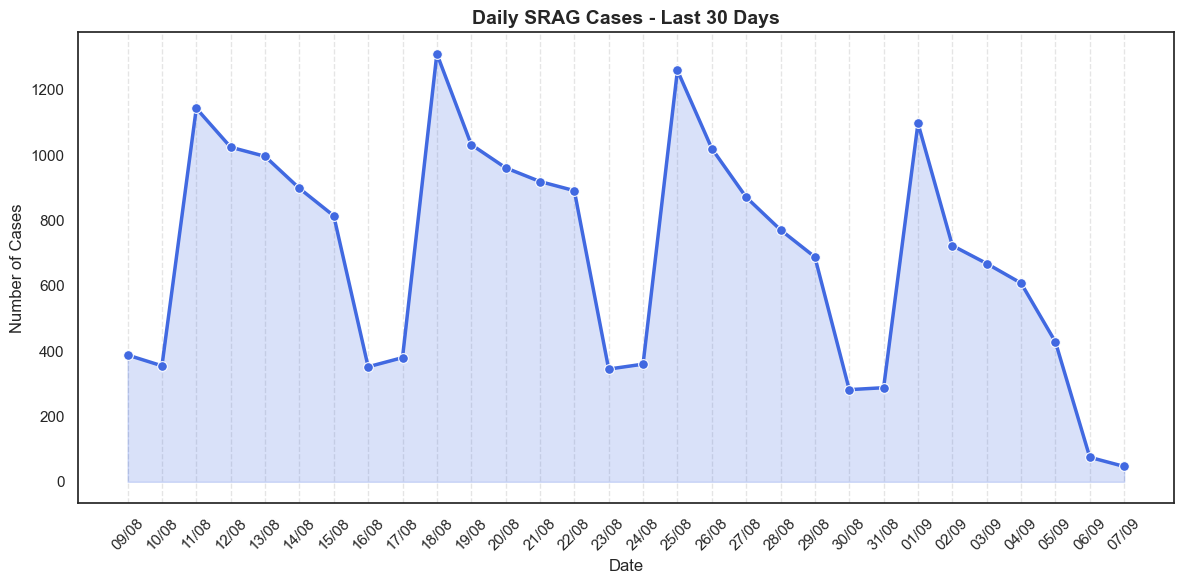

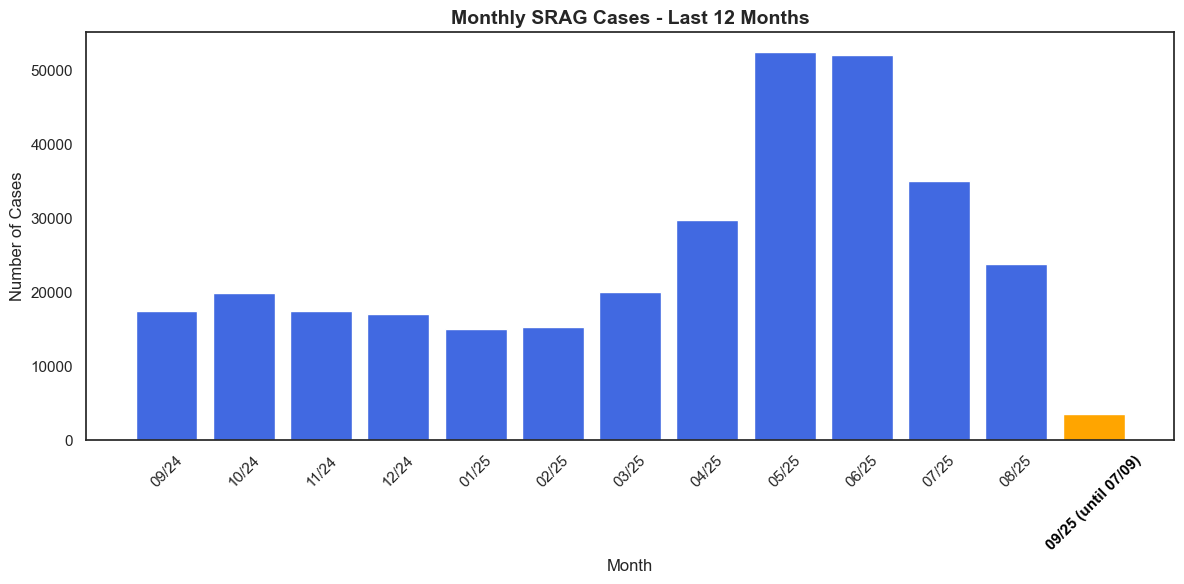

In [481]:
plot_case_trends(df_daily_info)